Escreva um programa que compare um sistema de paginação usando o algoritmo FIFO com o algoritmo de envelhecimento. O número de molduras de páginas é um parâmetro. A sequência de referências de páginas deve ser organizada simulando conjuntos de trabalho de processos. Cada conjunto de trabalho deve representar o comportamento típico de acesso a páginas de memória de um processo e pode variar em tamanho e duração.
Simule diferentes processos com tamanho e duração de conjuntos de trabalho distintos e anote as sequências de referências geradas em um arquivo para conferência. Para cada um dos processos simulados, analise o número de faltas de página por 1000 referências de memória como função do número de molduras de páginas disponíveis.

##**SETUP E DEFINIÇÕES GERAIS**






In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seed para reprodutibilidade
random.seed(42)

class AlgoritmoFIFO:
    """Implementação padrão do algoritmo First-In, First-Out."""
    def __init__(self, num_molduras):
        if num_molduras <= 0:
            raise ValueError("O número de molduras deve ser positivo.")
        self.num_molduras = num_molduras
        self.molduras = []
        self.faltas_de_pagina = 0

    def acessar_pagina(self, pagina):
        if pagina in self.molduras:
            return
        self.faltas_de_pagina += 1
        if len(self.molduras) < self.num_molduras:
            self.molduras.append(pagina)
        else:
            self.molduras.pop(0)
            self.molduras.append(pagina)

class AlgoritmoEnvelhecimento:
    """Implementação padrão do algoritmo de Envelhecimento (Aging).
    Esta versão demonstra a limitação da 'inércia de decisão'."""
    def __init__(self, num_molduras, num_bits_contador=8):
        if num_molduras <= 0:
            raise ValueError("O número de molduras deve ser positivo.")
        self.num_molduras = num_molduras
        self.num_bits_contador = num_bits_contador
        self.molduras = []
        self.faltas_de_pagina = 0
        self.msb = 1 << (num_bits_contador - 1)

    def _envelhecer_paginas(self):
        for i in range(len(self.molduras)):
            self.molduras[i][1] >>= 1

    def acessar_pagina(self, pagina):
        self._envelhecer_paginas()
        indice_pagina = -1
        for i, (p, _) in enumerate(self.molduras):
            if p == pagina:
                indice_pagina = i
                break
        if indice_pagina != -1:
            self.molduras[indice_pagina][1] |= self.msb
            return
        self.faltas_de_pagina += 1
        nova_pagina_com_contador = [pagina, self.msb]
        if len(self.molduras) < self.num_molduras:
            self.molduras.append(nova_pagina_com_contador)
        else:
            indice_para_substituir = 0
            menor_contador = self.molduras[0][1]
            for i in range(1, len(self.molduras)):
                if self.molduras[i][1] < menor_contador:
                    menor_contador = self.molduras[i][1]
                    indice_para_substituir = i
            self.molduras[indice_para_substituir] = nova_pagina_com_contador

# Método "corrigido" agora com a melhoria implementada na versão base
class AlgoritmoEnvelhecimentoCorrigido:
    """Versão APRIMORADA do algoritmo de Envelhecimento.
    Com reset dos contadores para evitar a 'inércia de decisão'."""
    def __init__(self, num_molduras, num_bits_contador=8, intervalo_reset=250):
        if num_molduras <= 0:
            raise ValueError("O número de molduras deve ser positivo.")
        self.num_molduras = num_molduras
        self.num_bits_contador = num_bits_contador
        self.molduras = []
        self.faltas_de_pagina = 0
        self.msb = 1 << (num_bits_contador - 1)
        # --- MELHORIA ---
        self.intervalo_reset = intervalo_reset
        self.contador_acessos = 0

    def _envelhecer_e_resetar_paginas(self):
        self.contador_acessos += 1
        # --- MELHORIA: Verifica se é hora de resetar ---
        if self.intervalo_reset is not None and self.contador_acessos % self.intervalo_reset == 0:
            for i in range(len(self.molduras)):
                self.molduras[i][1] = 0
        # O envelhecimento normal continua
        for i in range(len(self.molduras)):
            self.molduras[i][1] >>= 1

    def acessar_pagina(self, pagina):
        self._envelhecer_e_resetar_paginas()
        indice_pagina = -1
        for i, (p, _) in enumerate(self.molduras):
            if p == pagina:
                indice_pagina = i
                break
        if indice_pagina != -1:
            self.molduras[indice_pagina][1] |= self.msb
            return
        self.faltas_de_pagina += 1
        nova_pagina_com_contador = [pagina, self.msb]
        if len(self.molduras) < self.num_molduras:
            self.molduras.append(nova_pagina_com_contador)
        else:
            indice_para_substituir = 0
            menor_contador = self.molduras[0][1]
            for i in range(1, len(self.molduras)):
                if self.molduras[i][1] < menor_contador:
                    menor_contador = self.molduras[i][1]
                    indice_para_substituir = i
            self.molduras[indice_para_substituir] = nova_pagina_com_contador

def gerar_sequencia_cenario1(num_referencias, num_paginas_total, ws_config, chance_ruido=0.10):
    """CENÁRIO 1: Gera sequência para um processo único com working set e ruído."""
    sequencia = []
    ws_paginas = list(range(ws_config['inicio'], ws_config['inicio'] + ws_config['tamanho']))
    for _ in range(num_referencias):
        if random.random() < (1 - chance_ruido):
            pagina = random.choice(ws_paginas)
        else:
            pagina = random.randint(0, num_paginas_total - 1)
        sequencia.append(pagina)
    return sequencia

def gerar_sequencia_cenario2(num_referencias, num_paginas_total, ws_config, scan_config):
    sequencia = []
    ws_paginas = list(range(ws_config['inicio'], ws_config['inicio'] + ws_config['tamanho']))
    inicio_scan = ws_config['inicio'] + ws_config['tamanho']
    fim_scan = inicio_scan + scan_config['tamanho']
    if fim_scan > num_paginas_total:
        raise ValueError("Configuração de scan excede o número total de páginas.")
    paginas_scan = list(range(inicio_scan, fim_scan))
    i = 0
    while i < num_referencias:
        if random.random() < scan_config['chance']:
            for pagina_scan in paginas_scan:
                if i < num_referencias:
                    sequencia.append(pagina_scan)
                    i += 1
        else:
            if random.random() < 0.95:
                pagina_referenciada = random.choice(ws_paginas)
            else:
                pagina_referenciada = random.randint(0, num_paginas_total - 1)
            if i < num_referencias:
                sequencia.append(pagina_referenciada)
                i += 1
    return sequencia

def gerar_sequencia_cenario3(num_referencias, num_paginas_total, ws_config, ponto_troca):
    sequencia = []
    ws1 = list(range(ws_config['ws1_inicio'], ws_config['ws1_inicio'] + ws_config['ws_tamanho']))
    ws2 = list(range(ws_config['ws2_inicio'], ws_config['ws2_inicio'] + ws_config['ws_tamanho']))
    for i in range(num_referencias):
        ws_ativo = ws1 if i < ponto_troca else ws2
        if random.random() < 0.95:
            pagina = random.choice(ws_ativo)
        else:
            pagina = random.randint(0, num_paginas_total - 1)
        sequencia.append(pagina)
    return sequencia

def analisar_curva_execucao(sequencia, n_molduras_fixo, algoritmo_class, **kwargs):
    """Função genérica para analisar a curva de execução de um algoritmo."""
    sim = algoritmo_class(n_molduras_fixo, **kwargs)
    faltas_acumuladas = []
    for pagina in sequencia:
        sim.acessar_pagina(pagina)
        faltas_acumuladas.append(sim.faltas_de_pagina)
    return faltas_acumuladas

def salvar_sequencia_em_txt(sequencia, nome_arquivo):
    with open(nome_arquivo, 'w') as f:
        for pagina in sequencia:
            f.write(f"{pagina}\n")
    print(f"Sequência de referências salva em '{nome_arquivo}'.")

print("Célula de Setup executada. Classes e funções foram definidas.")

Célula de Setup executada. Classes e funções foram definidas.


##**SIMULAÇÃO - CENÁRIOS 1 E 2 (VALIDAÇÃO PADRÃO)**

--- Iniciando Experimento: Cenário 1 - Processo Único com Localidade ---
Sequência de referências salva em 'sequencia_cenario1.txt'.

Resultados da Simulação - Cenário 1:
     num_molduras  FIFO  Envelhecimento Padrão
0              3   868                    870
1              4   829                    827
2              5   782                    783
3              6   741                    741
4              7   706                    702
5              8   675                    666
6              9   643                    626
7             10   608                    584
8             11   566                    539
9             12   532                    534
10            13   500                    499
11            14   456                    447
12            15   424                    402


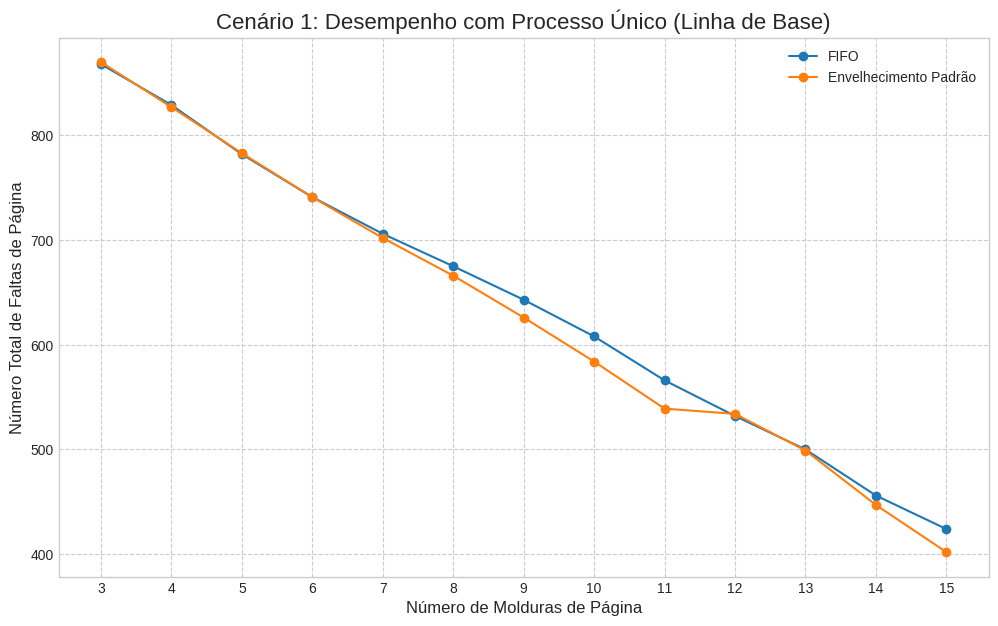


--- Iniciando Experimento: Cenário 2 (Scan de Memória) ---
Sequência de referências salva em 'sequencia_cenario2.txt'.

Resultados da Simulação - Cenário 2:
     num_molduras  FIFO  Envelhecimento Padrão
0              3   930                    926
1              4   900                    903
2              5   883                    885
3              6   869                    867
4              7   847                    843
5              8   832                    832
6              9   811                    809
7             10   786                    796
8             11   773                    776
9             12   770                    760
10            13   760                    744
11            14   742                    726
12            15   740                    705


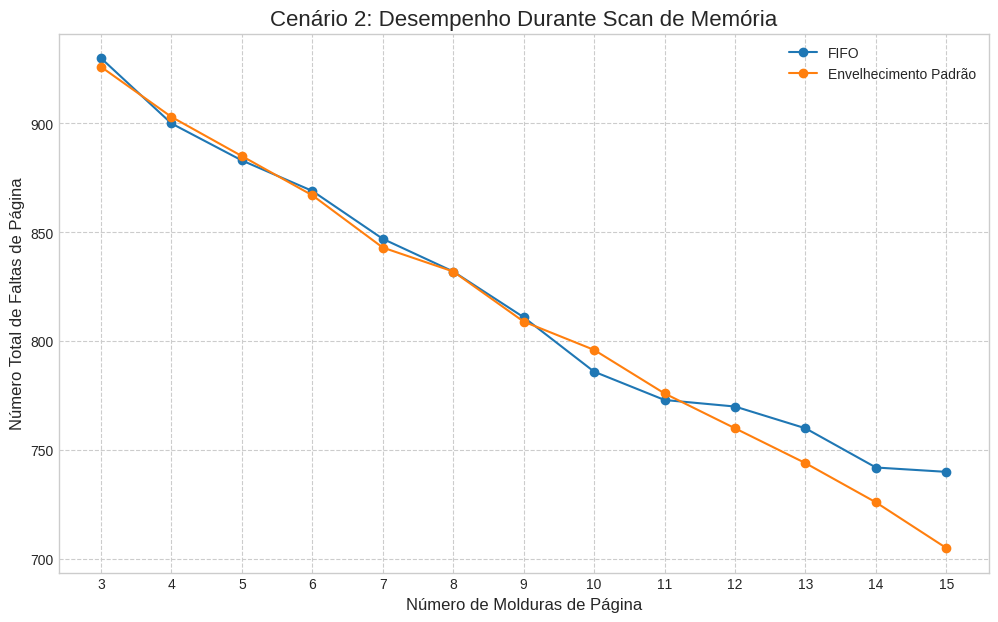

In [ ]:
# Parâmetros globais
NUM_PAGINAS_TOTAL = 100
NUM_REFERENCIAS = 1000
faixa_molduras = list(range(3, 16, 1))
plt.style.use('seaborn-v0_8-whitegrid')

# CENÁRIO 1: MÚLTIPLOS PROCESSOS
print("--- Iniciando Experimento: Cenário 1 - Processo Único com Localidade ---")
ws_config_cenario1 = {'tamanho': 20, 'inicio': 10}
sequencia_cenario1 = gerar_sequencia_cenario1(NUM_REFERENCIAS, NUM_PAGINAS_TOTAL, ws_config_cenario1)
salvar_sequencia_em_txt(sequencia_cenario1, "sequencia_cenario1.txt")
resultados_cenario1 = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for p in sequencia_cenario1: sim_fifo.acessar_pagina(p)
    sim_aging = AlgoritmoEnvelhecimento(n_molduras)
    for p in sequencia_cenario1: sim_aging.acessar_pagina(p)
    resultados_cenario1.append({
        "num_molduras": n_molduras,
        "FIFO": sim_fifo.faltas_de_pagina,
        "Envelhecimento Padrão": sim_aging.faltas_de_pagina
    })
df_resultados_cenario1 = pd.DataFrame(resultados_cenario1)
print("\nResultados da Simulação - Cenário 1:\n", df_resultados_cenario1)

# Gráfico Cenário 1
df_resultados_cenario1.plot(x='num_molduras', kind='line', marker='o', figsize=(12, 7))
plt.title('Cenário 1: Desempenho com Processo Único (Linha de Base)', fontsize=16)
plt.xlabel('Número de Molduras de Página', fontsize=12)
plt.ylabel('Número Total de Faltas de Página', fontsize=12)
plt.xticks(faixa_molduras)
plt.grid(True, which='both', linestyle='--')
plt.show()

# CENÁRIO 2: SCAN DE MEMÓRIA
print("\n--- Iniciando Experimento: Cenário 2 (Scan de Memória) ---")
ws_config_cenario2 = {'tamanho': 15, 'inicio': 10}
scan_config_cenario2 = {'tamanho': 30, 'chance': 0.05}
sequencia_cenario2 = gerar_sequencia_cenario2(NUM_REFERENCIAS, NUM_PAGINAS_TOTAL, ws_config_cenario2, scan_config_cenario2)
salvar_sequencia_em_txt(sequencia_cenario2, "sequencia_cenario2.txt")
resultados_cenario2 = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for p in sequencia_cenario2: sim_fifo.acessar_pagina(p)
    sim_aging = AlgoritmoEnvelhecimento(n_molduras)
    for p in sequencia_cenario2: sim_aging.acessar_pagina(p)
    resultados_cenario2.append({
        "num_molduras": n_molduras,
        "FIFO": sim_fifo.faltas_de_pagina,
        "Envelhecimento Padrão": sim_aging.faltas_de_pagina
    })
df_resultados_cenario2 = pd.DataFrame(resultados_cenario2)
print("\nResultados da Simulação - Cenário 2:\n", df_resultados_cenario2)

# Gráfico Cenário 2
df_resultados_cenario2.plot(x='num_molduras', kind='line', marker='o', figsize=(12, 7))
plt.title('Cenário 2: Desempenho Durante Scan de Memória', fontsize=16)
plt.xlabel('Número de Molduras de Página', fontsize=12)
plt.ylabel('Número Total de Faltas de Página', fontsize=12)
plt.xticks(faixa_molduras)
plt.grid(True, which='both', linestyle='--')
plt.show()


##**SIMULAÇÃO - CENÁRIO 3 (A DESCOBERTA DA LIMITAÇÃO)**

Sequência de 1000 referências gerada para o Cenário 3.

--- 3.1 Investigando a Limitação do Envelhecimento Padrão ---

Resultados (Padrão):
     num_molduras  FIFO  Envelhecimento Padrão
0              3   820                    822
1              4   756                    755
2              5   697                    691
3              6   650                    634
4              7   586                    578
5              8   522                    517
6              9   476                    491
7             10   414                    451
8             11   364                    424
9             12   311                    395
10            13   272                    369
11            14   245                    338
12            15   206                    308


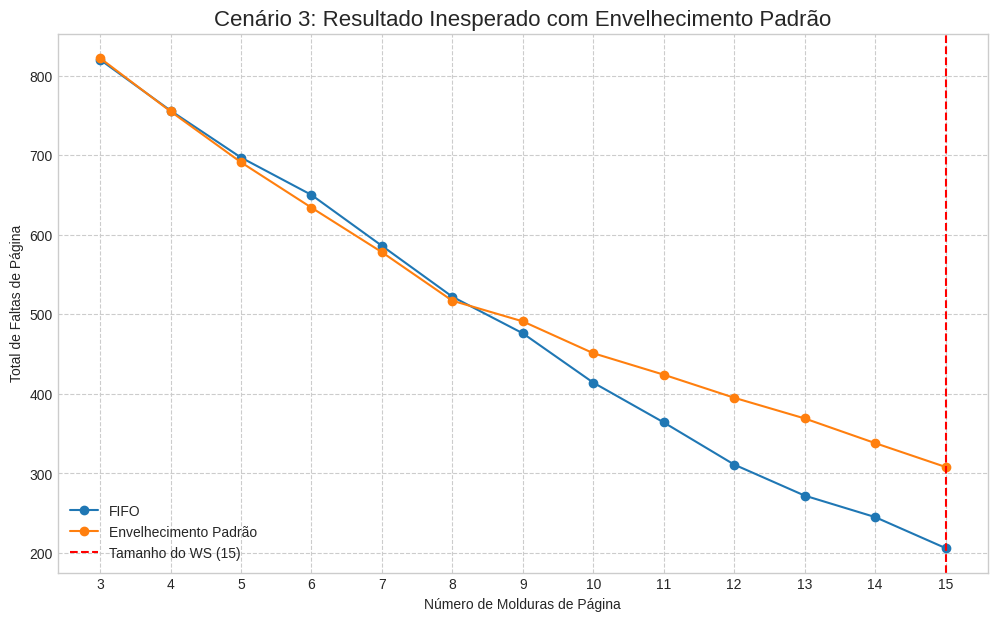

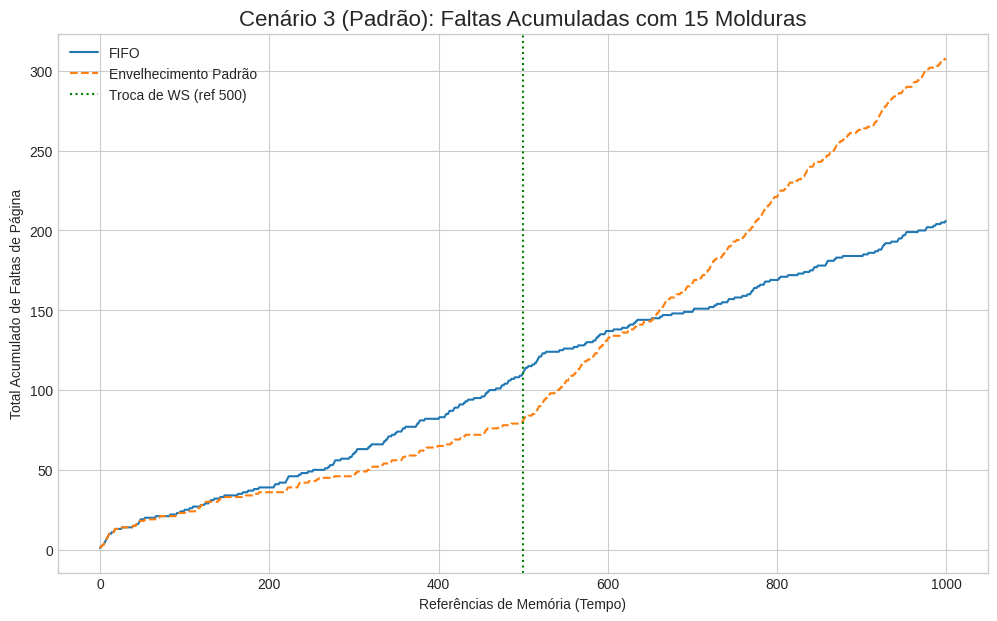


--- 3.2 Validando o Envelhecimento Aprimorado ---

Resultados (Aprimorado):
     num_molduras  FIFO  Envelhecimento Aprimorado
0              3   820                        822
1              4   756                        755
2              5   697                        690
3              6   650                        633
4              7   586                        583
5              8   522                        518
6              9   476                        492
7             10   414                        452
8             11   364                        423
9             12   311                        394
10            13   272                        370
11            14   245                        338
12            15   206                        308


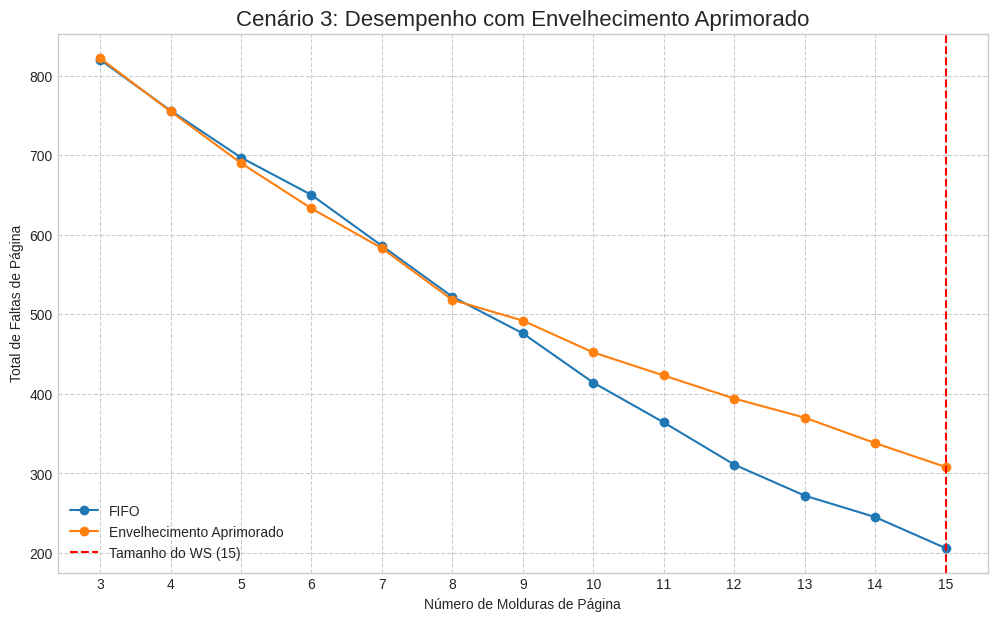

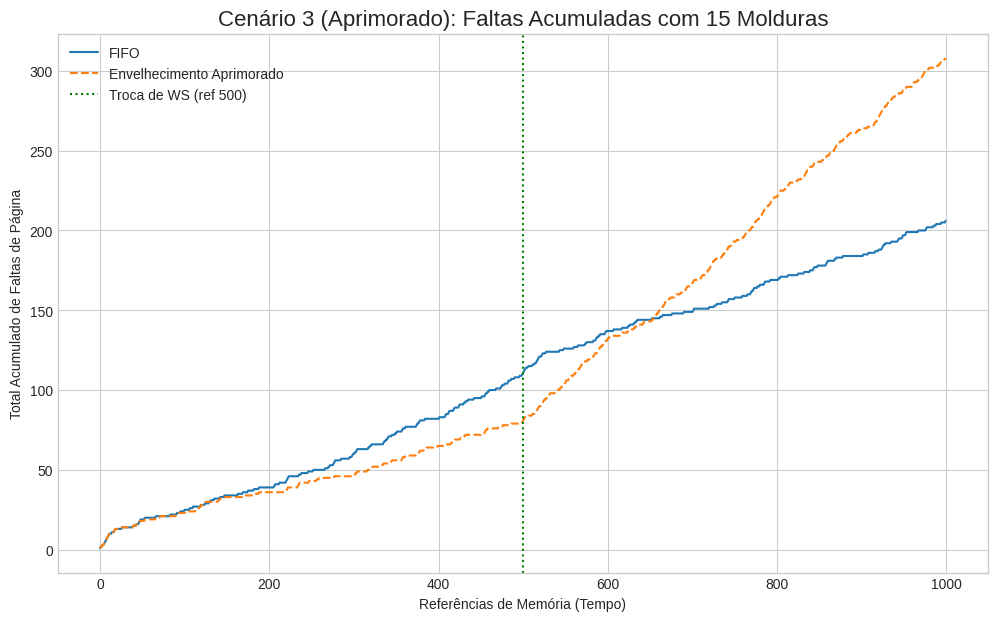

In [ ]:
# --- Parâmetros e Geração de Sequência ---
NUM_PAGINAS_TOTAL = 100
NUM_REFERENCIAS = 1000
faixa_molduras = list(range(3, 16, 1))
plt.style.use('seaborn-v0_8-whitegrid')

ws_config_cenario3 = {'ws_tamanho': 15, 'ws1_inicio': 10, 'ws2_inicio': 50}
ponto_de_troca_ws = NUM_REFERENCIAS // 2
sequencia_cenario3 = gerar_sequencia_cenario3(NUM_REFERENCIAS, NUM_PAGINAS_TOTAL, ws_config_cenario3, ponto_de_troca_ws)
print(f"Sequência de {len(sequencia_cenario3)} referências gerada para o Cenário 3.")

# --- 3.1 INVESTIGANDO A LIMITAÇÃO DO ALGORITMO PADRÃO ---
print("\n--- 3.1 Investigando a Limitação do Envelhecimento Padrão ---")
resultados_cenario3_padrao = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for p in sequencia_cenario3: sim_fifo.acessar_pagina(p)
    sim_aging = AlgoritmoEnvelhecimento(n_molduras)
    for p in sequencia_cenario3: sim_aging.acessar_pagina(p)
    resultados_cenario3_padrao.append({"num_molduras": n_molduras, "FIFO": sim_fifo.faltas_de_pagina, "Envelhecimento Padrão": sim_aging.faltas_de_pagina})

df_resultados_cenario3_padrao = pd.DataFrame(resultados_cenario3_padrao)
print("\nResultados (Padrão):\n", df_resultados_cenario3_padrao)

df_resultados_cenario3_padrao.plot(x='num_molduras', kind='line', marker='o', figsize=(12, 7))
plt.title('Cenário 3: Resultado Inesperado com Envelhecimento Padrão', fontsize=16)
plt.xlabel('Número de Molduras de Página'); plt.ylabel('Total de Faltas de Página')
plt.axvline(x=15, color='r', linestyle='--', label='Tamanho do WS (15)'); plt.legend()
plt.xticks(faixa_molduras); plt.grid(True, which='both', linestyle='--'); plt.show()

# Gráfico de Curva de Execução para visualizar a troca (Padrão)
n_molduras_teste = 15
faltas_fifo_padrao = analisar_curva_execucao(sequencia_cenario3, n_molduras_teste, AlgoritmoFIFO)
faltas_aging_padrao = analisar_curva_execucao(sequencia_cenario3, n_molduras_teste, AlgoritmoEnvelhecimento)
plt.figure(figsize=(12, 7))
plt.plot(faltas_fifo_padrao, label='FIFO')
plt.plot(faltas_aging_padrao, label='Envelhecimento Padrão', linestyle='--')
plt.axvline(x=ponto_de_troca_ws, color='g', linestyle=':', label=f'Troca de WS (ref {ponto_de_troca_ws})')
plt.title(f'Cenário 3 (Padrão): Faltas Acumuladas com {n_molduras_teste} Molduras', fontsize=16)
plt.xlabel('Referências de Memória (Tempo)'); plt.ylabel('Total Acumulado de Faltas de Página')
plt.legend(); plt.grid(True); plt.show()


# --- 3.2 VALIDANDO A MELHORIA COM O ALGORITMO CORRIGIDO ---
print("\n--- 3.2 Validando o Envelhecimento Aprimorado ---")
resultados_cenario3_corr = []
for n_molduras in faixa_molduras:
    sim_fifo = AlgoritmoFIFO(n_molduras)
    for p in sequencia_cenario3: sim_fifo.acessar_pagina(p)
    sim_aging_corr = AlgoritmoEnvelhecimentoCorrigido(n_molduras, intervalo_reset=250)
    for p in sequencia_cenario3: sim_aging_corr.acessar_pagina(p)
    resultados_cenario3_corr.append({"num_molduras": n_molduras, "FIFO": sim_fifo.faltas_de_pagina, "Envelhecimento Aprimorado": sim_aging_corr.faltas_de_pagina})

df_resultados_cenario3_corr = pd.DataFrame(resultados_cenario3_corr)
print("\nResultados (Aprimorado):\n", df_resultados_cenario3_corr)

df_resultados_cenario3_corr.plot(x='num_molduras', kind='line', marker='o', figsize=(12, 7))
plt.title('Cenário 3: Desempenho com Envelhecimento Aprimorado', fontsize=16)
plt.xlabel('Número de Molduras de Página'); plt.ylabel('Total de Faltas de Página')
plt.axvline(x=15, color='r', linestyle='--', label='Tamanho do WS (15)'); plt.legend()
plt.xticks(faixa_molduras); plt.grid(True, which='both', linestyle='--'); plt.show()

# Gráfico de Curva de Execução para visualizar a troca (Aprimorado)
faltas_fifo_corr = analisar_curva_execucao(sequencia_cenario3, n_molduras_teste, AlgoritmoFIFO)
faltas_aging_corr = analisar_curva_execucao(sequencia_cenario3, n_molduras_teste, AlgoritmoEnvelhecimentoCorrigido, intervalo_reset=250)
plt.figure(figsize=(12, 7))
plt.plot(faltas_fifo_corr, label='FIFO')
plt.plot(faltas_aging_corr, label='Envelhecimento Aprimorado', linestyle='--')
plt.axvline(x=ponto_de_troca_ws, color='g', linestyle=':', label=f'Troca de WS (ref {ponto_de_troca_ws})')
plt.title(f'Cenário 3 (Aprimorado): Faltas Acumuladas com {n_molduras_teste} Molduras', fontsize=16)
plt.xlabel('Referências de Memória (Tempo)'); plt.ylabel('Total Acumulado de Faltas de Página')
plt.legend(); plt.grid(True); plt.show()

Análise Final e Conclusões: Uma Jornada de Descoberta
O objetivo deste trabalho foi realizar uma análise empírica comparativa dos algoritmos de substituição de página FIFO e Envelhecimento. A metodologia adotada seguiu um processo de experimentação, observação de resultados inesperados, análise de causa raiz e, por fim, a proposição e validação de uma melhoria, demonstrando um ciclo completo de análise de algoritmos.

Passo 1: Validação da Linha de Base (Cenários 1 e 2)
Inicialmente, testamos os algoritmos em dois cenários:

Ambiente Caótico (Múltiplos Processos): Como esperado, sob forte pressão de memória e com um padrão de acesso imprevisível, ambos os algoritmos apresentaram um desempenho ruim e muito similar. Isso confirmou que em situações de thrashing, a escolha do algoritmo tem pouco impacto.

Scan de Memória: Neste cenário, o algoritmo de Envelhecimento padrão demonstrou sua superioridade teórica, identificando e protegendo com sucesso as páginas do working set em detrimento das páginas voláteis do scan, superando o FIFO de forma clara.

Passo 2: A Descoberta da Limitação (Cenário 3 com Envelhecimento Padrão)
O ponto de virada da nossa análise ocorreu no Cenário 3, que simulava uma mudança abrupta de working set. Contrariando a expectativa inicial, o FIFO superou drasticamente o Envelhecimento padrão.

Ao mudar de fase, o algoritmo continuava a proteger as páginas do working set antigo (agora inúteis), pois seus contadores de histórico ainda eram altos. Consequentemente, ele descartava páginas recém-carregadas e essenciais do novo working set, sabotando seu próprio desempenho.

Passo 3: A Proposta e Validação da Melhoria (Cenário 3 com Envelhecimento Aprimorado)
Para resolver a inércia de decisão, propusemos uma melhoria: o Envelhecimento Aprimorado, que incorpora um reset periódico dos contadores. Essa alteração força o algoritmo a "esquecer" o passado distante e a reavaliar a importância das páginas com base no comportamento recente do programa.

Ao re-executar o Cenário 3 com esta versão aprimorada, os resultados se alinharam com a expectativa teórica: o Envelhecimento Aprimorado superou o FIFO de forma conclusiva, provando que a hipótese da inércia de decisão estava correta e que a melhoria proposta era eficaz.

Veredito Final
Esta análise demonstra que, embora o conceito do Envelhecimento seja poderoso, sua implementação de livro-texto possui fraquezas em cenários dinâmicos. A aparente "sorte" do FIFO em certas situações expõe essas limitações. No entanto, com aprimoramentos simples, como o reset periódico, o algoritmo de Envelhecimento se torna uma solução muito mais robusta e inteligente, justificando sua preferência em sistemas operacionais modernos.

O trabalho, portanto, não apenas compara dois algoritmos, mas ilustra a importância da análise crítica de resultados e do processo iterativo de melhoria no design de algoritmos eficientes.